<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

**1.1 Импортируем необходимые библиотеки.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor, cv


RANDOM_STATE = 12345

**1.2 Пользовательские функции.**

Напишем функцию для первичной проверки данных:

In [2]:
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

**1.3 Загрузим данные.**

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


**1.4 Первичный осмотр данных.**

Описательный анализ:

In [5]:
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
(26496, 1)

Проверка пропусков
Количество пропусков: 0
Доля пропусков: nan%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  26415

Первые пять строк датасета


/tmp/ipykernel_188/4076587887.py:6: RuntimeWarning: invalid value encountered in long_scalars
  missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


Проверим, в хронологическом ли порядке расположены даты и время:

In [6]:
df.sort_index(inplace=True)

print(df.index.is_monotonic)

True


True - порядок соблюдён.

Выполним ресемплирование по одному часу:

In [7]:
df = df.resample('1H').sum()

**Вывод:**
- в таблице 26496 записей;
- пропущенных значений нет;
- данные с 2018-03-01 00:00:00 до 2018-08-31 23:50:00;
- выполнено ресемплирование по 1 часу.

## Анализ

Построим график ресемплированных данных:

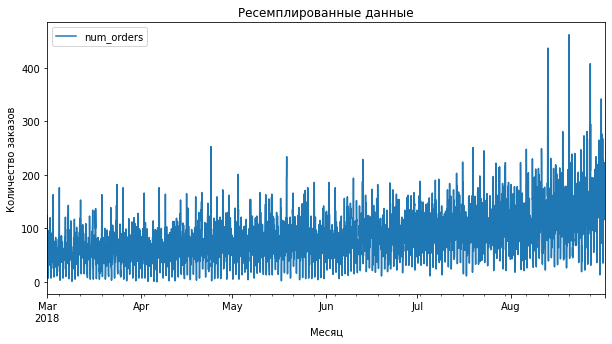

In [8]:
df.plot(figsize = (10,5))
plt.title('Ресемплированные данные')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

На графике видно увеличение количества заказов.

Чтобы лучше понимать временной ряд, разберём тренды и сезонность:

In [9]:
decomposed = seasonal_decompose(df)

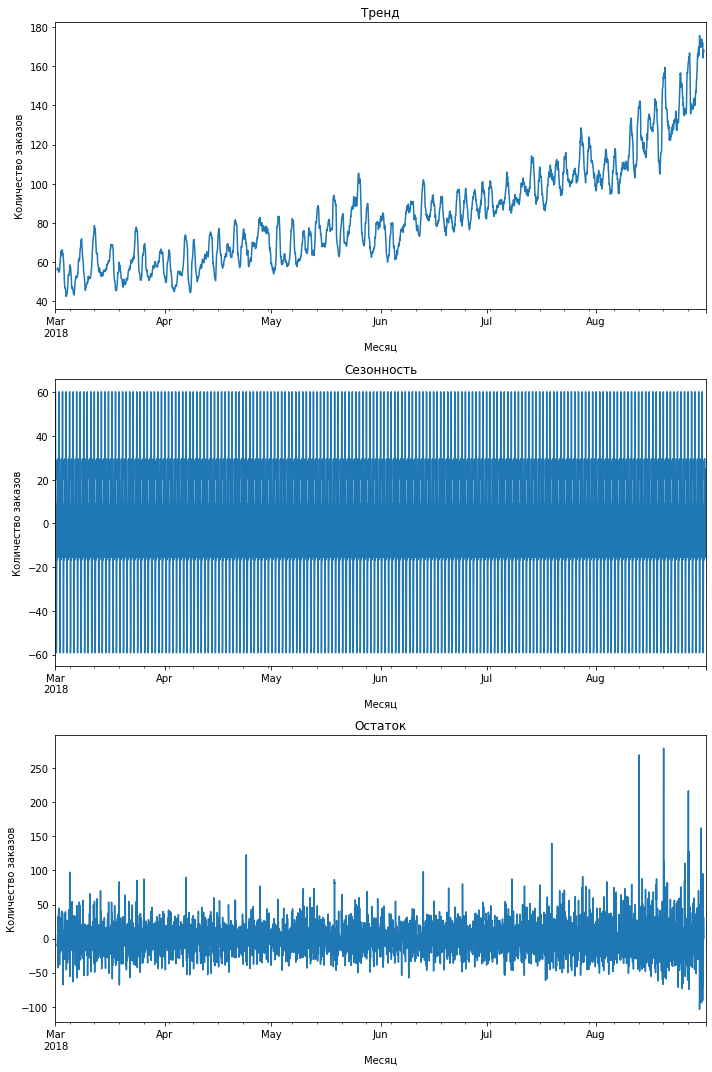

In [10]:
plt.figure(figsize=(10, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.tight_layout()

На графиках видно суточную сезонность, растущий тренд и высокую частотность.

Уменьшим временной интервал до недели:

In [11]:
decomposed_week = seasonal_decompose(df['2018-08-25':])

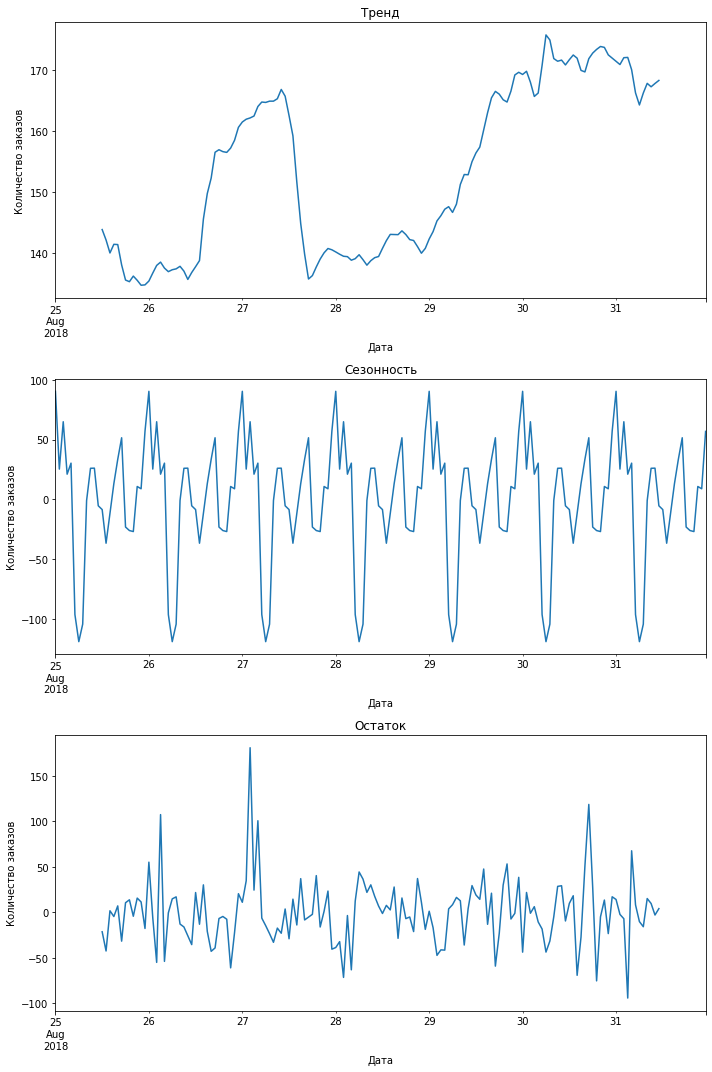

In [12]:
plt.figure(figsize=(10, 15))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(312)

decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(313)

decomposed_week.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

На графике тренда видно рост количества заказов в понедельник, спад в середине недели и увеличение количества заказов к выходным.

На графике сезонности видно рост количества заказов в вечернее-ночное время суток и спад утром.

Уменьшим временной интервал до одних суток:

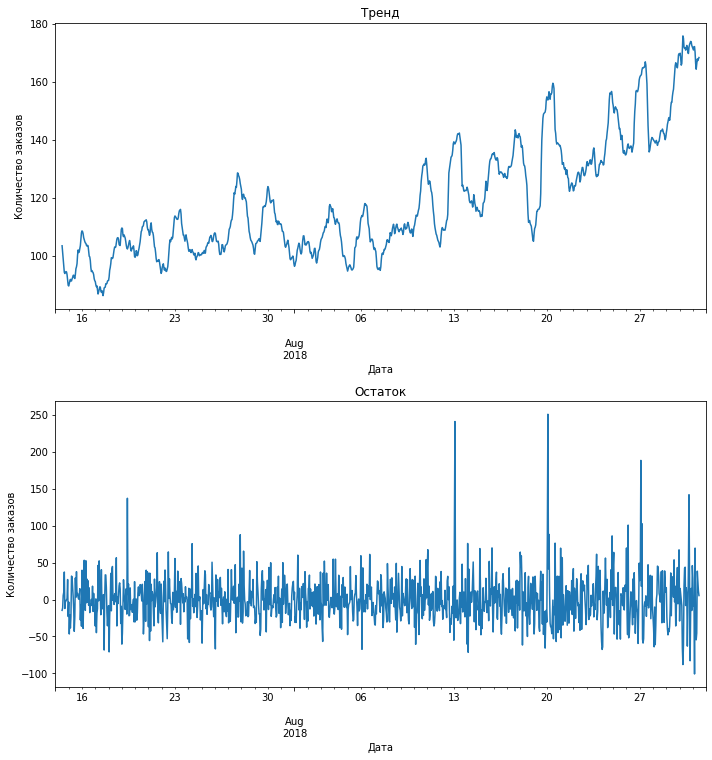

In [13]:
decomposed_1 = seasonal_decompose(df['2018-07-14':])
plt.figure(figsize=(10, 15))

plt.subplot(311)
decomposed_1.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(312)

decomposed_1.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

In [14]:
decomposed_1_day = seasonal_decompose(df['2018-08-30':])

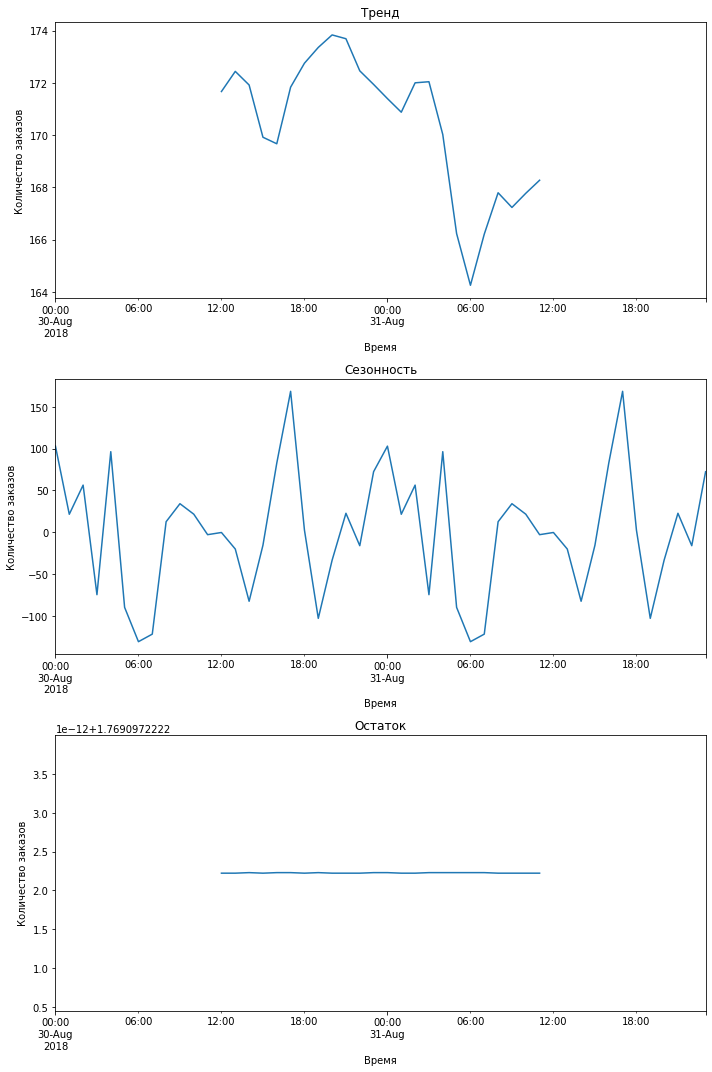

In [15]:
plt.figure(figsize=(10, 15))

plt.subplot(311)
decomposed_1_day.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(312)

decomposed_1_day.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(313)

decomposed_1_day.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.tight_layout()

На графиках видно, что в 6-7 утра меньше всего заказов, больше всего в 16-18 вечера.

**2.1 Проверим ряд на стационарность.**

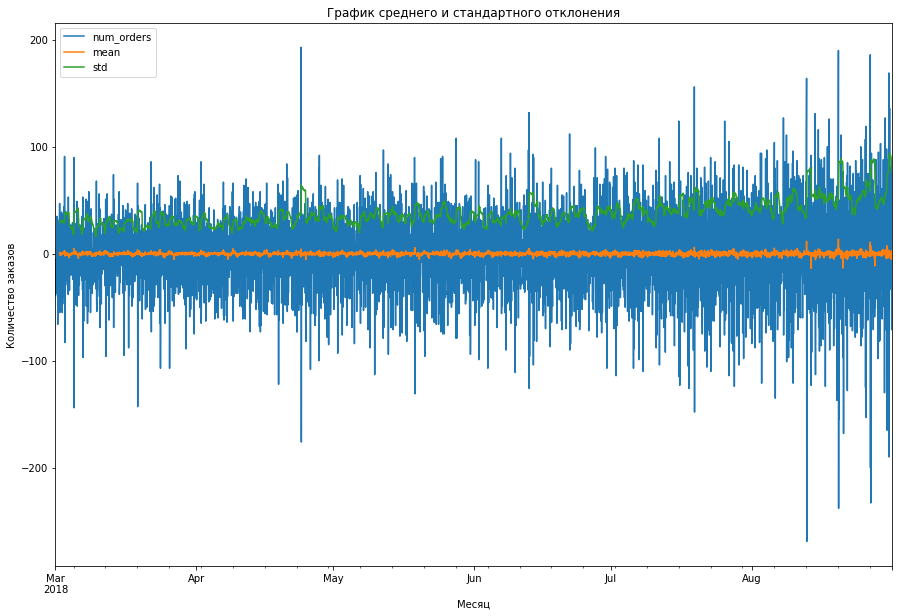

In [16]:
df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(24).mean()
df_shift['std'] = df_shift['num_orders'].rolling(24).std()
df_shift.plot(figsize=(15,10)) 
plt.title('График среднего и стандартного отклонения')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Наш ряд стационарный. 

In [17]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')




Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


**Вывод:** \
**На графиках видно суточную сезонность, растущий тренд и высокую частотность:**
- рост количества заказов в понедельник, спад в середине недели и увеличение количества заказов к выходным;
- в 6-7 утра меньше всего заказов, больше всего в 16-18 вечера;
- ряд стационарный.

**Необходимые нам признаки:**
- День недели;
- Часы.

## Обучение

**3.1 Напишем функцию для создания признаков.**

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

Т.к. нам необходимо сделать прогноз на 1 час вперёд, lag будет = 168, а окно = 7:

In [19]:
make_features(df, 168, 7)

print(df)

                     num_orders  day  dayofweek  hour  lag_1  lag_2  lag_3  \
datetime                                                                     
2018-03-01 00:00:00         124    1          3     0    NaN    NaN    NaN   
2018-03-01 01:00:00          85    1          3     1  124.0    NaN    NaN   
2018-03-01 02:00:00          71    1          3     2   85.0  124.0    NaN   
2018-03-01 03:00:00          66    1          3     3   71.0   85.0  124.0   
2018-03-01 04:00:00          43    1          3     4   66.0   71.0   85.0   
...                         ...  ...        ...   ...    ...    ...    ...   
2018-08-31 19:00:00         136   31          4    19  207.0  217.0  197.0   
2018-08-31 20:00:00         154   31          4    20  136.0  207.0  217.0   
2018-08-31 21:00:00         159   31          4    21  154.0  136.0  207.0   
2018-08-31 22:00:00         223   31          4    22  159.0  154.0  136.0   
2018-08-31 23:00:00         205   31          4    23  223.0  15

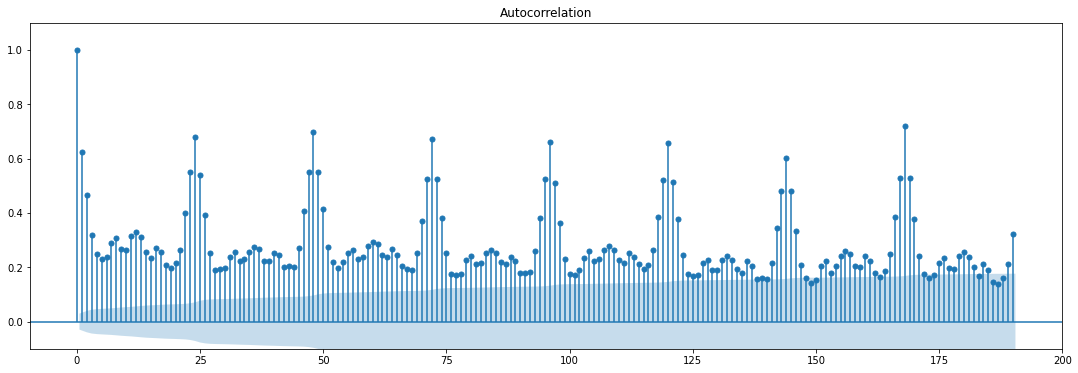

In [20]:
# Код ревьюера
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


Разделим данные на обучающую и тестовую выборки (доля тестовой по условию = 10%):

In [21]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
    
x_train = train.drop('num_orders',axis=1)
x_test = test.drop('num_orders',axis=1)
y_train = train['num_orders']
y_test = test['num_orders']

In [22]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3806, 172), (3806,), (442, 172), (442,))

In [23]:
x_train.head(3)

,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,8,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,86.000000
2018-03-08 01:00:00,8,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,99.571429
2018-03-08 02:00:00,8,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,96.571429


**3.2  _Линейная регрессия._**

In [24]:
%%time

# Обозначим модель

model_lr = LinearRegression()

rmse = cross_val_score(model_lr, 
                        x_train, 
                        y_train, 
                        scoring='neg_root_mean_squared_error', 
                        cv=TimeSeriesSplit(n_splits=5))

print('Значение метрики RMSE для линейной регрессии:', np.mean(-rmse))

Значение метрики RMSE для линейной регрессии: 23.780096977746272
CPU times: user 1.8 s, sys: 4.6 s, total: 6.4 s
Wall time: 6.35 s


**3.3  _Случайный лес._**

In [25]:
# Обозначим модель

model_rfr = RandomForestRegressor(random_state = RANDOM_STATE)

# Зададим параметры
param_grid_rfr = {'n_estimators': range(5, 30, 5),
                  'max_depth': range(1, 15, 2),
                  'min_samples_leaf': range(1,5),
                  'min_samples_split': range(2,8,2)}

In [26]:
%%time

# Подберем гиперпараметры
grid_rfr = RandomizedSearchCV(
    model_rfr, param_grid_rfr, 
    scoring='neg_root_mean_squared_error', 
    cv=TimeSeriesSplit(n_splits=5), 
    random_state=RANDOM_STATE)

# Обучим модель  
model_rfr = grid_rfr.fit(x_train, y_train)

CPU times: user 1min 12s, sys: 0 ns, total: 1min 12s
Wall time: 1min 12s


In [27]:
print(f'Лучшие параметры для случайного леса: ', model_rfr.best_params_)
print(f'Значение метрики RMSE для лучших параметров случайного леса: %.4f' % -model_rfr.best_score_)

Лучшие параметры для случайного леса:  {'n_estimators': 25, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 11}
Значение метрики RMSE для лучших параметров случайного леса: 23.2187


**3.3  _LightGBM._**

In [28]:
# Обозначим модель

model_lgbm = LGBMRegressor(n_jobs=2,
                           verbose=10,
                           seed=RANDOM_STATE)

# Зададим параметры
param_grid_lgbm = {'learning_rate': np.logspace(-3, 0, 5),
                   'n_estimators': range(20, 81, 20),
                   'num_leaves': range(20, 61, 10),
                   'force_col_wise': [True]}

In [29]:
%%time

# Подберем гиперпараметры
grid_lgbm = RandomizedSearchCV(
    model_lgbm, param_grid_lgbm, 
    scoring='neg_root_mean_squared_error', 
    cv=TimeSeriesSplit(n_splits=5))

# Обучим модель  
model_lgbm = grid_lgbm.fit(x_train, y_train)

[LightGBM] [Info] Total Bins 17097
[LightGBM] [Info] Number of data points in the train set: 636, number of used features: 172
[LightGBM] [Info] Start training from score 57.938679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leave

In [30]:
print(f'Лучшие параметры для LightGBM: ', model_lgbm.best_params_)
print(f'Значение метрики RMSE для лучших параметров LightGBM : %.4f' % -model_lgbm.best_score_)

Лучшие параметры для LightGBM:  {'num_leaves': 20, 'n_estimators': 60, 'learning_rate': 0.1778279410038923, 'force_col_wise': True}
Значение метрики RMSE для лучших параметров LightGBM : 23.4552


**3.4 _CatBoost._**

In [31]:
# Обозначим модель

model_cb = CatBoostRegressor(loss_function='RMSE',
                             verbose=50,
                             random_seed=RANDOM_STATE)

# Зададим параметры
param_grid_cb = {'learning_rate': np.logspace(-3, 0, 5),
                 'n_estimators' : range (50,100),
                 'max_depth' : range(5, 7, 10)}

In [32]:
%%time

# Подберем гиперпараметры
grid_cb = RandomizedSearchCV(
    model_cb, param_grid_cb, 
    scoring='neg_root_mean_squared_error', 
    cv=TimeSeriesSplit(n_splits=5), 
    random_state=RANDOM_STATE)

# Обучим модель  
model_cb = grid_cb.fit(x_train, y_train)

0:	learn: 21.1963780	total: 64.9ms	remaining: 3.9s
50:	learn: 1.8533938	total: 839ms	remaining: 165ms
60:	learn: 1.2739113	total: 969ms	remaining: 0us
0:	learn: 21.6825407	total: 26.8ms	remaining: 1.61s
50:	learn: 5.4434907	total: 806ms	remaining: 158ms
60:	learn: 4.3023085	total: 964ms	remaining: 0us
0:	learn: 22.0005514	total: 19.2ms	remaining: 1.15s
50:	learn: 7.5452643	total: 910ms	remaining: 178ms
60:	learn: 6.4411592	total: 1.11s	remaining: 0us
0:	learn: 22.4878712	total: 23.7ms	remaining: 1.42s
50:	learn: 9.7205599	total: 1.05s	remaining: 205ms
60:	learn: 8.6830606	total: 1.25s	remaining: 0us
0:	learn: 23.2831507	total: 21.2ms	remaining: 1.27s
50:	learn: 11.3015018	total: 1.04s	remaining: 204ms
60:	learn: 10.1763541	total: 1.24s	remaining: 0us
0:	learn: 29.4880683	total: 13.1ms	remaining: 865ms
50:	learn: 26.2368962	total: 766ms	remaining: 240ms
66:	learn: 25.3648281	total: 994ms	remaining: 0us
0:	learn: 30.8460648	total: 15.7ms	remaining: 1.04s
50:	learn: 27.2092649	total: 913m

In [33]:
print(f'Лучшие параметры для CatBoost: ', model_cb.best_params_)
print(f'Значение метрики RMSE для лучших параметров CatBoost: %.4f' % -model_cb.best_score_)

Лучшие параметры для CatBoost:  {'n_estimators': 81, 'max_depth': 5, 'learning_rate': 0.1778279410038923}
Значение метрики RMSE для лучших параметров CatBoost: 22.6829


In [34]:
results = {
    'Model' : ['LinearRegression', 'RandomForest', 'LightGBM', 'CatBoost'],
    'RMSE' :pd.Series([np.mean(-rmse), -model_rfr.best_score_, -model_lgbm.best_score_, -model_cb.best_score_])}
display(pd.DataFrame(results))

,Model,RMSE
0,LinearRegression,23.780097
1,RandomForest,23.218652
2,LightGBM,23.455238
3,CatBoost,22.682902


**Вывод:** \
Лучший результат у модели CatBoost:
- Лучшие параметры для CatBoost:  {'n_estimators': 81, 'max_depth': 5, 'learning_rate': 0.1778279410038923}
- Значение метрики RMSE для лучших параметров CatBoost: 22.6829

## Тестирование

**4.1 Проверим наши модели на тестовой выборке:**

**4.1.1  _Линейная регрессия._**

In [35]:
model_lr.fit(x_train, y_train)

prediction_lr = model_lr.predict(x_test)
result_lr = mean_squared_error(y_test, prediction_lr)** 0.5

print(f'Значение метрики RMSE для лучшей модели Линейной регрессии: %.4f' % result_lr)

Значение метрики RMSE для лучшей модели Линейной регрессии: 34.4982


Визуализируем предсказания модели и сравним их с правильными ответами:

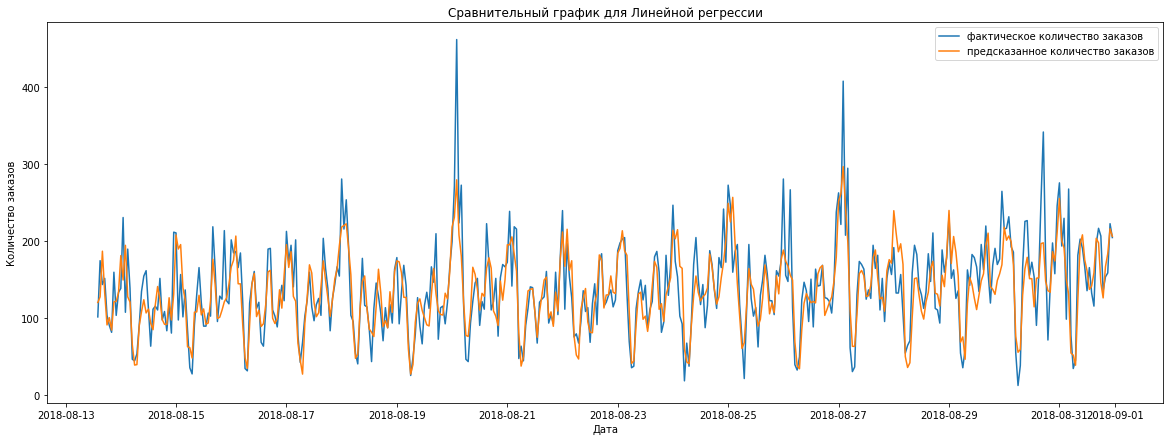

In [36]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(x_test.index, y_test, label='фактическое количество заказов')
ax.plot(x_test.index, prediction_lr, label='предсказанное количество заказов')
plt.title('Сравнительный график для Линейной регрессии')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

**4.1.2 _Случайный лес._**

In [37]:
prediction_rfr = model_rfr.predict(x_test)
result_rfr = mean_squared_error(y_test, prediction_rfr)** 0.5

print(f'Значение метрики RMSE для лучшей модели Случайного леса: %.4f' % result_rfr)

Значение метрики RMSE для лучшей модели Случайного леса: 38.5892


Визуализируем предсказания модели и сравним их с правильными ответами:

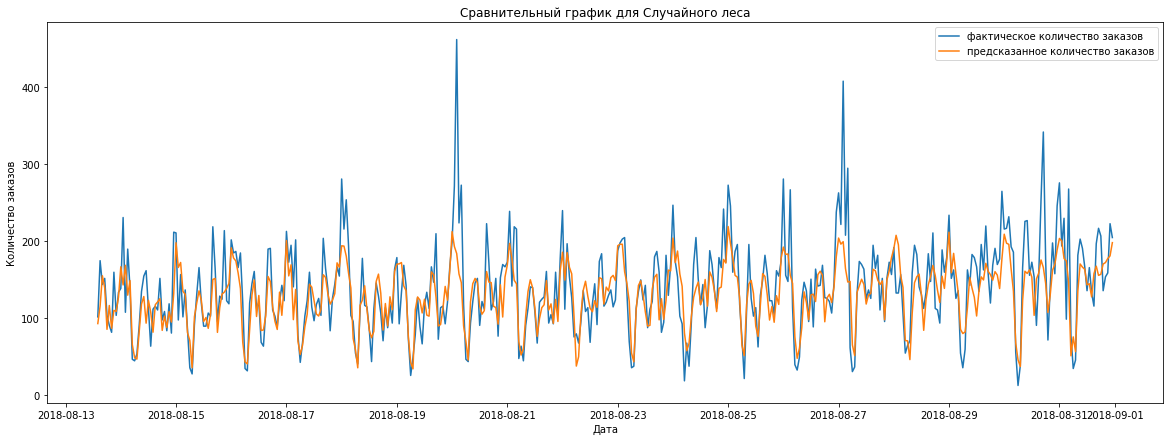

In [38]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(x_test.index, y_test, label='фактическое количество заказов')
ax.plot(x_test.index, prediction_rfr, label='предсказанное количество заказов')
plt.title('Сравнительный график для Случайного леса')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

**4.1.3  _LightGBM._**

In [39]:
prediction_lgbm = model_lgbm.predict(x_test)
result_lgbm = mean_squared_error(y_test, prediction_lgbm)** 0.5

print(f'Значение метрики RMSE для лучшей модели LightGBM.: %.4f' % result_lgbm)

Значение метрики RMSE для лучшей модели LightGBM.: 37.0307


Визуализируем предсказания модели и сравним их с правильными ответами:

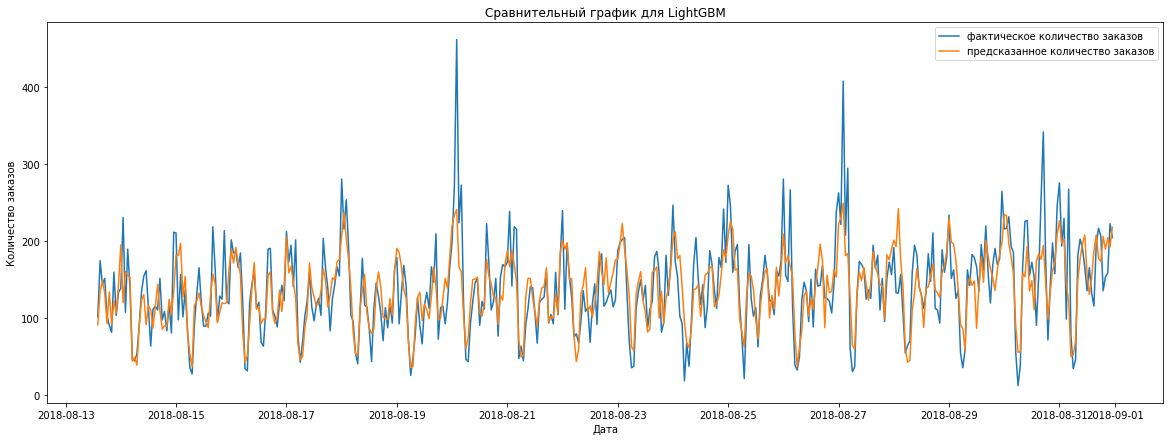

In [40]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(x_test.index, y_test, label='фактическое количество заказов')
ax.plot(x_test.index, prediction_lgbm, label='предсказанное количество заказов')
plt.title('Сравнительный график для LightGBM')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

**4.1.4 _CatBoost._**

In [41]:
prediction_cb = model_cb.predict(x_test)
result_cb = mean_squared_error(y_test, prediction_cb)** 0.5

print(f'Значение метрики RMSE для лучшей модели CatBoost: %.4f' % result_cb)

Значение метрики RMSE для лучшей модели CatBoost: 38.9415


Визуализируем предсказания модели и сравним их с правильными ответами:

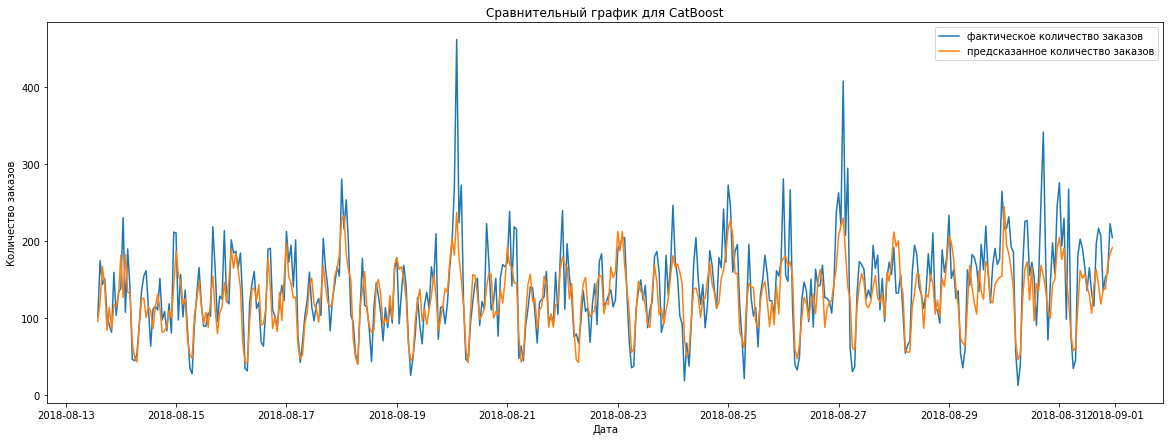

In [42]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(x_test.index, y_test, label='фактическое количество заказов')
ax.plot(x_test.index, prediction_cb, label='предсказанное количество заказов')
plt.title('Сравнительный график для CatBoost')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

По графикам видно, что модели CatBoost и Случайного леса чаще ошибаются в предсказаниях.

LightGBM и Линейной регрессии - наоборот, делают хорошие предсказания и лучше схватывают пиковые значения.

In [43]:
results = {
    'Model' : ['LinearRegression', 'RandomForest', 'LightGBM', 'CatBoost'],
    'RMSE на тестовой выборке' :pd.Series([result_lr, 
                                           result_rfr, 
                                           result_lgbm, 
                                           result_cb])}
display(pd.DataFrame(results))

,Model,RMSE на тестовой выборке
0,LinearRegression,34.498155
1,RandomForest,38.589163
2,LightGBM,37.030728
3,CatBoost,38.941511


Значение метрики RMSE для лучшей модели Линейной регрессии: 34.498155. 

**4.2 Проверим модель на адекватность:**

In [44]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
pred_rmse = mean_squared_error(y_test, pred_previous)** 0.5

print('Значение метрики RMSE для проверки модели на адекватность:', pred_rmse)

Значение метрики RMSE для проверки модели на адекватность: 58.856486242815066


**Модель адекватна:**
- Значение метрики RMSE для проверки модели на адекватность: 58.856486242815066
- Значение метрики RMSE для лучшей модели Линейной регрессии: 34.498155.

**Общий вывод:**
1. **_Были подготовлены данные:_**
- в таблице 26496 записей;
- пропущенных значений нет;
- данные с 2018-03-01 00:00:00 до 2018-08-31 23:50:00;
- выполнено ресемплирование по 1 часу.

2. **_Был произведён анализ данных:_** 
**На графиках видно суточную сезонность, растущий тренд и высокую частотность:**
- рост количества заказов в понедельник, спад в середине недели и увеличение количества заказов к выходным;
- в 6-7 утра меньше всего заказов, больше всего в 16-18 вечера;
- ряд стационарный.

**Необходимые нам признаки:**
- День недели;
- Часы.

3. **_Были обучены модели:_**

| Model | RMSE |
|---|---|
| LinearRegression | 23.780097 |
| RandomForest | 23.218652 |
|LightGBM | 23.455238 |
|CatBoost | 22.682902 |

**Лучший результат у модели CatBoost:**
- Лучшие параметры для CatBoost:  {'n_estimators': 81, 'max_depth': 5, 'learning_rate': 0.1778279410038923}
- Значение метрики RMSE для лучших параметров CatBoost: 22.6829

4. **_Были протестированы модели и построены сравнительные графики:_**

| Model | RMSE на тестовой выборке |
|---|---|
| LinearRegression | 34.498155 |
| RandomForest | 38.589163 |
|LightGBM | 37.030728 |
|CatBoost | 38.941511 |

Самой эффективной моделью (на тестовой выборке) оказалась - LinearRegression, о чем свидетелствует финальный график. \
Условие - "Значение метрики RMSE на тестовой выборке должно быть не больше 48" - выполнено.

**5. Выполнена проверка модели на адекватность:**
- Значение метрики RMSE для проверки модели на адекватность: 58.856486242815066
- Значение метрики RMSE для лучшей модели Линейной регрессии: 34.498155.
- модель адекватна.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48